In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras import utils
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

2025-12-02 14:49:52.546529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 14:49:52.546595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 14:49:52.548309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 14:49:52.559173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load MNIST to 28*28*1 (1 channel:grey) + normalize between 0 & 1
def load_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    X = x_train.astype('float32') / 255.0
    X = X.reshape(-1, 28, 28, 1)
    y = y_train.reshape(-1, 1)

    X_t = x_test.astype('float32') / 255.0
    X_t = X_t.reshape(-1, 28, 28, 1)
    y_t = y_test.reshape(-1, 1)
    
    return X,y,X_t,y_t

# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(X, y_cat, model, title="", log=False):
    y_pred = model.predict(X).argmax(axis=1)
    cm = confusion_matrix(y_cat.argmax(axis=1), y_pred)
    
    plt.figure(figsize=(8,6))
    if log:
        plt.imshow(np.log1p(cm), interpolation='nearest', cmap='Blues')
    else:
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.colorbar()
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(100*cm[i, j] / len(y_pred), '.2f'), 
                    ha="center", va="center", color="green")
    plt.tight_layout()
    plt.show()

## Let's load the different Train & Test data

In [4]:
X,y,X_t,y_t = load_mnist()

print(f"MNIST loaded: \n\tX   {X.shape}\n\ty   {y.shape}\n\tX_t {X_t.shape}\n\ty_t {y_t.shape}")

MNIST loaded: 
	X   (60000, 28, 28, 1)
	y   (60000, 1)
	X_t (10000, 28, 28, 1)
	y_t (10000, 1)


We use MNIST dataset

 * The dataset has 70000 rows and each row has 785 columns
 * In each row the first 784 is a 28x28 pixel grayscale (0-255) image of a hand written number
 * The last number is the number on the image

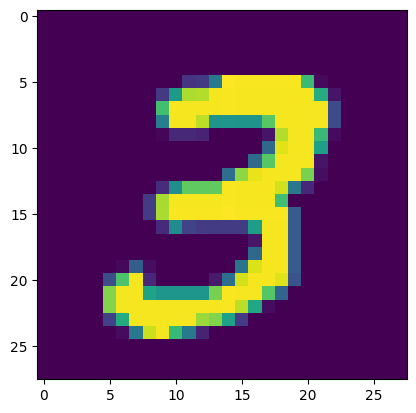

In [5]:
plt.imshow(X[7])

Create the network

In [6]:
classifier = Sequential()

# Convolutional Layer
classifier.add(Conv2D(6, (3, 3), input_shape=(28, 28, 1), activation='relu'))
# classifier.add(MaxPooling2D(pool_size=(2, 2))) # take the max in each 2*2 window: divides size by 2*2
classifier.add(Dropout(.05)) # replace 10% of the outputs by 0 to reduce over-fitting # disabled when predicted

classifier.add(Flatten()) # Once the convolutions are done, we flatten to get an array

# Dense Hidden Layer
classifier.add(Dense(8, activation='relu'))
# classifier.add(Dropout(.10))

# Output Layer for Classification
classifier.add(Dense(10, activation='softmax'))

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 dropout (Dropout)           (None, 26, 26, 6)         0         
                                                                 
 flatten (Flatten)           (None, 4056)              0         
                                                                 
 dense (Dense)               (None, 8)                 32456     
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 32606 (127.37 KB)
Trainable params: 32606 (127.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2025-12-02 14:50:0

Compile

In [7]:
classifier.compile( optimizer = 'rmsprop', 
                    loss = tf.keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

Create categorical data (i.e [1, 2] becomes [[1, 0, 0], [0, 1, 0]])

In [8]:
y_cat = to_categorical(y)
yt_cat = to_categorical(y_t)

In [9]:
print(f"train sizes: X: {X.shape} ; y: {y_cat.shape}\ntest  sizes: X: {X_t.shape} ; y: {yt_cat.shape}")

train sizes: X: (60000, 28, 28, 1) ; y: (60000, 10)
test  sizes: X: (10000, 28, 28, 1) ; y: (10000, 10)


**Train the model**

In [10]:
history = classifier.fit(X, y_cat, batch_size=64, epochs=5, verbose=1, validation_data=(X_t, yt_cat))

Epoch 1/5
938/938 [==============================] - 19s 20ms/step - loss: 0.5638 - accuracy: 0.8364 - val_loss: 0.3945 - val_accuracy: 0.8893
Epoch 2/5
938/938 [==============================] - 18s 19ms/step - loss: 0.3046 - accuracy: 0.9136 - val_loss: 0.2342 - val_accuracy: 0.9370
Epoch 3/5
938/938 [==============================] - 18s 19ms/step - loss: 0.2011 - accuracy: 0.9442 - val_loss: 0.1561 - val_accuracy: 0.9563
Epoch 4/5
938/938 [==============================] - 18s 20ms/step - loss: 0.1483 - accuracy: 0.9577 - val_loss: 0.1231 - val_accuracy: 0.9636
Epoch 5/5
938/938 [==============================] - 18s 20ms/step - loss: 0.1197 - accuracy: 0.9650 - val_loss: 0.1073 - val_accuracy: 0.9694


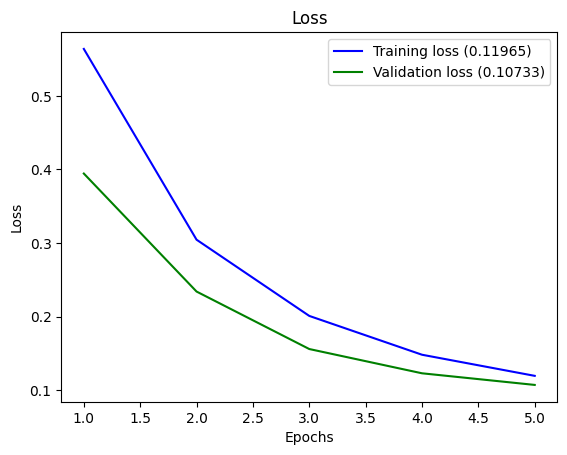

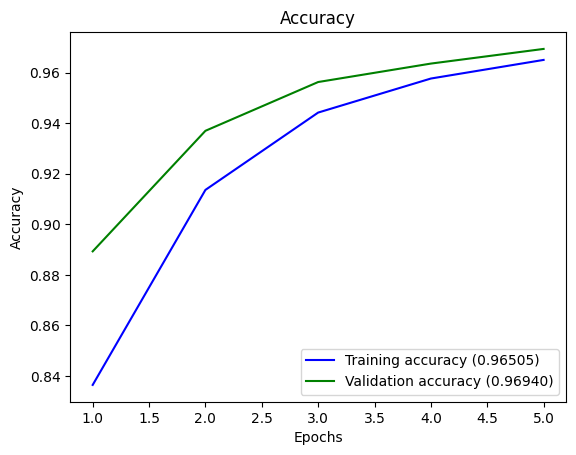

In [11]:
plot_history(history)

### Evaluate the model
Les matrices de confusions affichent les pourcentages et sont colorées de manière logarithmique

1875/1875 [==============================] - 7s 4ms/step


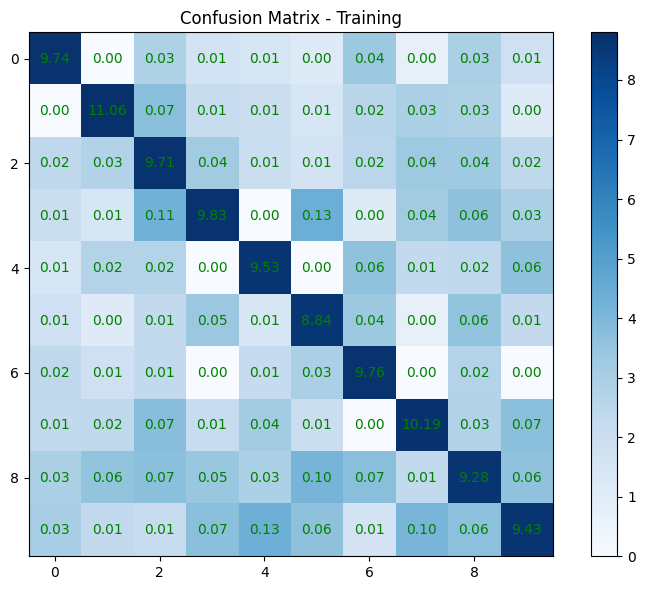

313/313 [==============================] - 2s 4ms/step


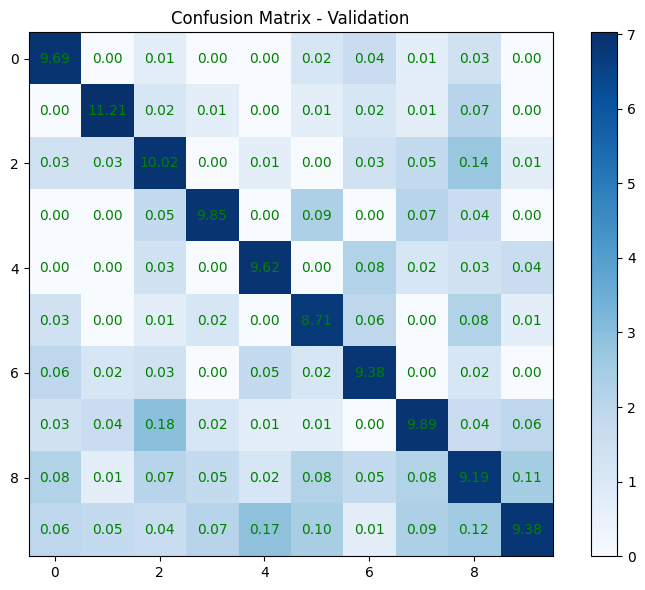

In [12]:
plot_confusion_matrix(X, y_cat, classifier, 'Training', log=True)
plot_confusion_matrix(X_t, yt_cat, classifier, 'Validation', log=True)

In [ ]:
classifier.save('/work/mnist_classifier_model.keras')